# MAST Plasma Equilibrium Prediction

This notebook demonstrates how to infer two-dimensional poloidal flux maps from diagnostic measurements using outputs of the EFIT++ equilibrium reconstruction code
to train and test our models.

## Overview

This project represents the third data science challenge from the ITER International School 2024 series. The challenge focuses on:

1. Applying signal selection techniques to diverse input sets
2. Implementing effective normalization strategies 
3. Learning to predict 2D spatial targets from 1D signal inputs

![Equilibrium Animation](../media/images/equilibrium.gif)

## Key Challenge Concepts

- **Signal Processing**: Handle heterogeneous diagnostic signals from tokamak experiments
- **Dimensionality Transformation**: Convert 1D time-series inputs to 2D spatial maps
- **Validation Methods**: Develop metrics to evaluate flux map prediction accuracy

The EFIT++ code reconstructs plasma equilibrium by combining external and internal diagnostic measurements. The animation above shows the time evolution of poloidal flux contours generated by EFIT++ for one MAST shot from the training dataset. Note that while displayed as mirrored for illustration, the plasma equilibria are axisymmetric and recorded on a poloidal r, z plane.

**Challenge Goal**: Predict 2D poloidal flux maps from diverse diagnostic measurements.

Data for this project comes from the open-source MAST Data Catalog. Thanks to Samuel Jackson, Nathan Cummings, Saiful Khan, and the wider MAST community for curating this FAIR dataset.

## Problem Description

Poloidal magnetic flux represents the integral of the vertical magnetic field component passing through a disc. This disc is bound by an r, z point on the poloidal plane and aligned with the z-axis. Poloidal magnetic flux is measured in Wb (Weber).

In this challenge, you must predict both:
1. The shape of the poloidal flux map
2. The flux values at various time points

The training dataset contains 1D and 2D inputs from these MAST signal groups:
- dalpha
- magnetics
- soft_x_rays
- thomson_scattering

A key aspect of this challenge involves selecting the optimal diagnostic groups and signals to maximize the fit between your training data and unseen targets. Success requires both intuition about input signal meanings and systematic experimentation. Consider applying transformations to the input dataset to generate additional useful signals.

Note that the provided signals span widely different scales. Developing effective preprocessing steps to normalize your inputs is essential for good results.

Below, I include a comparison between EFIT++ ground truth and predictions from a simple linear regression model.

### Dataset Information

The data files are located in the `./fair_mast_data/plasma_equilibrium` directory:

#### Available Files
- `train.nc` - Training dataset in netCDF format
- `test.nc` - Test dataset in netCDF format

These files use the netCDF format, which is optimized for scientific data. I recommend using the `xarray` library to open and explore them. See the Example section below for demonstration on opening, examining, and formatting this data.

## Implementation Example

We'll begin by importing the necessary libraries, following the same approach used in the Plasma Current and Plasma Volume challenges.

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import seaborn as sns
import sklearn.metrics
import sklearn.pipeline
import xarray as xr


Next, we'll load our training and test datasets. We've placed these files in a subfolder within the project directory.

In [16]:
path = pathlib.Path().absolute().parent / "fair_mast_data/plasma_equilibrium"
train = xr.open_dataset(path / "train.nc")
test = xr.open_dataset(path / "test.nc")

print(train)


<xarray.Dataset> Size: 15MB
Dimensions:                  (center_column_channel: 5, time: 404,
                              coil_currents_channel: 6,
                              coil_voltages_channel: 4, flux_loops_channel: 6,
                              outer_discrete_channel: 8,
                              saddle_coils_channel: 4, hcam_l_channel: 18,
                              hcam_u_channel: 18, major_radius: 65, z: 65,
                              tcam_channel: 18)
Coordinates:
  * center_column_channel    (center_column_channel) <U10 200B 'XMA_CCBV04' ....
  * coil_currents_channel    (coil_currents_channel) <U20 480B 'AMC_P3L COIL ...
  * coil_voltages_channel    (coil_voltages_channel) <U12 192B '/xdc/pf/f/p1'...
  * flux_loops_channel       (flux_loops_channel) <U12 288B 'AMB_FL/CC03' ......
  * outer_discrete_channel   (outer_discrete_channel) <U9 288B 'XMA_OBR03' .....
  * saddle_coils_channel     (saddle_coils_channel) <U15 240B 'XMB_SAD/OUT/M0...
  * time        

After loading the data, we can examine how it's structured using xarray's capabilities. The `filter_by_attrs` function is particularly useful for exploring the dataset. Here are some examples of how to use it:

In [17]:
print(train.filter_by_attrs(units="Wb"))  # all attributes with units of Weber
print(train.filter_by_attrs(units="V"))  # all attributes with units of Volts
print(train.filter_by_attrs(group="magnetics"))  # all attributes in the magnetics group


<xarray.Dataset> Size: 23kB
Dimensions:             (flux_loops_channel: 6, time: 404)
Coordinates:
  * flux_loops_channel  (flux_loops_channel) <U12 288B 'AMB_FL/CC03' ... 'AMB...
  * time                (time) float64 3kB 0.0044 0.0094 ... 0.1788 0.1838
Data variables:
    flux_loops          (flux_loops_channel, time) float64 19kB ...
<xarray.Dataset> Size: 259kB
Dimensions:                  (center_column_channel: 5, time: 404,
                              coil_voltages_channel: 4,
                              outer_discrete_channel: 8,
                              saddle_coils_channel: 4, hcam_l_channel: 18,
                              hcam_u_channel: 18, tcam_channel: 18)
Coordinates:
  * center_column_channel    (center_column_channel) <U10 200B 'XMA_CCBV04' ....
  * coil_voltages_channel    (coil_voltages_channel) <U12 192B '/xdc/pf/f/p1'...
  * outer_discrete_channel   (outer_discrete_channel) <U9 288B 'XMA_OBR03' .....
  * saddle_coils_channel     (saddle_coils_channel) 

To identify all available groups in this dataset, run the following command:

In [18]:
print(np.unique([array.group for array in test.values() if hasattr(array, 'group')]))


['dalpha' 'magnetics' 'soft_x_rays' 'thomson_scattering']


In [19]:
def to_pandas(dataset: xr.Dataset, attrs: list[str]) -> pd.DataFrame:
    """Return set of Dataset attributes as a concatenated Pandas DataFrame."""
    return pd.concat(
        [dataset[attr].transpose("time", ...).to_pandas() for attr in attrs], axis=1
    )

# Data Preparation

For this example, we'll select only the `flux_loops` from our training set. Here's the process:

1. Extract signals (X) and targets (y) from the dataset
2. Split them into local training and test sets

I've chosen to isolate a single complete shot as our test set by filtering on the `shot_index` attribute. This approach enables the creation of a more coherent GIF animation for demonstration purposes.

Consider whether this splitting strategy is optimal. Can you think of alternative ways to divide the dataset?

Note that the poloidal flux map target has dimensions of (time, z, major_radius). To make it compatible with most machine learning libraries, we need to reshape it to a (nsamples, nsignals) block.

In [20]:
signals = ["flux_loops"]  # select input signals
X = to_pandas(train, signals)
y = train.magnetic_flux.data.reshape((train.sizes["time"], -1))

# generate train and test set based on shot index
index = train.shot_index.values == 3
X_train, X_test, y_train, y_test = X[~index], X[index], y[~index], y[index]


### Model Training and Evaluation

With our data prepared, we can now:

1. Set up our processing pipeline
2. Fit the model to our training data
3. Evaluate its performance

Keep in mind that for this equilibrium reconstruction challenge, you should consider:
- Selecting more advanced models than simple linear regression
- Including data preprocessing steps
- Implementing hyperparameter tuning

In [23]:
pipeline = sklearn.pipeline.make_pipeline(
    sklearn.linear_model.LinearRegression()
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

error = sklearn.metrics.mean_absolute_error(y_test, y_pred)
print(f"mean absolute error {error:1.6f}")


mean absolute error 0.004822


### Making Predictions and Generating Submissions

After validating our model performance, we can generate predictions for the test dataset and prepare a submission file:

In [22]:
# make predictions for test set
magnetic_flux = pipeline.predict(to_pandas(test, signals))

submission = pd.DataFrame(magnetic_flux)
submission.index.name = "index"
submission.to_csv(path / "submission.csv")


## Results Visualization

While not mandatory for model training, visualizing the comparison between your predictions and the EFIT++ ground truth provides valuable insights. The helper class below facilitates creating these visualizations and animations.

In [ ]:
from dataclasses import dataclass, field
from functools import cached_property

@dataclass
class Contour:
    """Manage multiple contour plots."""

    magnetic_flux: xr.DataArray | None = None
    levels: int = 31
    _handles: list = field(init=False, repr=False, default_factory=list)

    @cached_property
    def axes(self):
        """Manage axes instance."""
        self.fig, axes = plt.subplots(figsize=(3, 4.5))
        axes.set_aspect("equal")
        axes.set_axis_off()
        return axes

    @cached_property
    def shape(self):
        """Return flux map 2D shape."""
        return self.magnetic_flux.sizes["z"], self.magnetic_flux.sizes["major_radius"]

    def plot(self, data: xr.DataArray | np.ndarray = None, label=None, **kwargs):
        """Create contour map from magnetic flux data, store contour levels."""
        if isinstance(data, xr.DataArray):
            self.magnetic_flux = data
            data = data.values
        kwargs = {"colors": "gray", "linestyles": "-", "levels": self.levels} | kwargs
        try:
            contour = self.axes.contour(
                self.magnetic_flux.major_radius,
                self.magnetic_flux.z,
                data.reshape(self.shape),
                **kwargs,
            )
        except AttributeError:
            raise AttributeError(
                "Grid coordinates major_radius and z not found on "
                "magnetic_flux DataArray."
            )
        self.levels = contour.levels
        if label:
            color = kwargs.get("colors", "gray")
            self._handles.append(
                plt.matplotlib.lines.Line2D([0], [0], label=label, color=color)
            )
        return contour

    def legend(self):
        """Add legend to plot."""
        plt.legend(
            handles=self._handles, loc="center", bbox_to_anchor=[0.5, 1.08], ncol=1
        )
        self._handles = []

    def __call__(self, efit: np.ndarray, prediction: np.ndarray):
        """Plot a comparision between EFIT++ ground truth and prediction."""
        return [
            self.plot(efit, colors="gray", label="EFIT++"),
            self.plot(prediction, colors="C0", label="Prediction"),
        ]

    def _next_image(self, efit: np.ndarray, prediction: np.ndarray) -> PIL.Image.Image:
        """Yield poloidal flux contour images."""
        del self.axes  # clear instance axes
        self._handles = []  # clear legend handles
        self.levels = np.linspace(efit.min(), efit.max(), 51)
        contours = self(efit[-1], prediction[-1])
        self.legend()
        for _efit, _prediction in zip(efit, prediction):
            for contour in contours:
                contour.remove()
            contours = self(_efit, _prediction)
            self.fig.canvas.draw()
            yield PIL.Image.fromarray(np.array(self.fig.canvas.buffer_rgba()))

    def to_gif(self, efit: np.ndarray, prediction: np.ndarray):
        """Save gif animation of frame-wise efit-prediction mapping."""
        imgs = [image for image in self._next_image(efit, prediction)]
        imgs[0].save(
            path / "equilibrium_animation.gif",
            save_all=True,
            append_images=imgs,
            duration=100,
            loop=0,
            minimize_size=True,
        )


### Using the Contour Class

To use the visualization tools, we first initialize the `Contour` class with a `magnetic_flux` DataArray. This provides the dimensions and coordinates of the poloidal flux grid to the instance.

In [25]:
sns.set_context("notebook")
contour = Contour(train.magnetic_flux)


Individual frames at a specific time index can be visualized by calling the instance with test and prediction targets:

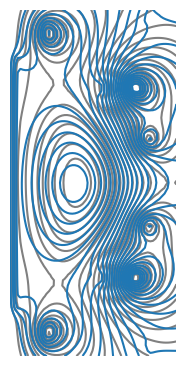

In [26]:
time_index = 20
contour(y_test[time_index], y_pred[time_index])


To visualize the temporal evolution of your model's predictions, you can generate a GIF animation by calling the `to_gif` function with complete test and prediction arrays:

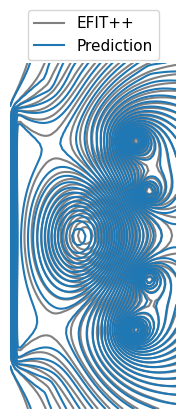

In [27]:
contour.to_gif(y_test, y_pred)

### Animation: Comparison of Model Predictions to Ground Truth

The animation below shows how our model predictions (blue) compare to the EFIT++ ground truth (gray) over time:

![Equilibrium Animation Comparison](../fair_mast_data/plasma_equilibrium/equilibrium_animation.gif)
